In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

np.random.seed(2002)

# Реализация линейной модели

In [ ]:
def full_sample_matrix(samples):
    samples_matrix = samples.copy()
    if samples.ndim == 1:
        samples_matrix = samples_matrix.reshape(-1, 1)

    ones_vec = np.ones((samples_matrix.shape[0], 1))
    return np.hstack([ones_vec, samples_matrix])

def linear_model(w, x_s):
    return np.matmul(full_sample_matrix(x_s), w)

# Реализация функции ошибок: **MSE** + $L_2$-регуляризатор

In [ ]:
def cost(w, **kwargs):
    x_sample = kwargs['x']
    y_sample = kwargs['y']
    alpha_reg = kwargs['alpha_reg']

    y_new = linear_model(w, x_sample)

    c = sum((y_sample - y_new) ** 2) / len(y_sample)

    # L2 регуляризация
    c += alpha_reg * sum(w ** 2)
    return c

# Реализация градиентного спуска

In [ ]:
class GDLinearRegression:

    def __init__(self, tol=1E-4, alpha=1, step_coef=1E-2):
        self.w = None
        self.tol = tol
        self.alpha = alpha
        self.step_coef = step_coef

    def fit(self, X, y):
        cost_args = {
            "x": X,
            "y": y,
            "alpha_reg": self.alpha
        }

        features_num = np.shape(X)[1]

        X_sample = full_sample_matrix(X)
        w = np.random.randn(features_num + 1, )

        costs = []
        while True:
            y_pred = X_sample.dot(w)
            error = y_pred - y

            curr_cost = cost(w, **cost_args)

            gradient = (1 / X_sample.shape[0]) * (X_sample.T.dot(error) + self.alpha * w)
            w = w - self.step_coef * gradient

            costs.append(curr_cost)
            if len(costs) >= 2 and abs(costs[-1] - costs[-2]) < self.tol:
                break
        self.w = w

# Реализация стохастического градиентного спуска

In [ ]:
class SGDLinearRegression:

    def __init__(self, tol=1E-4, alpha=1, step_coef=1E-2, iterations_cnt=1000):
        self.w=None
        self.tol=tol
        self.alpha=alpha
        self.step_coef = step_coef
        self.iterations_cnt = iterations_cnt

    def fit(self, X, y):
        samples_num = np.shape(X)[0]
        features_num = np.shape(X)[1]
        X = np.concatenate((np.ones((samples_num, 1)), X), axis=1)
        self.w = np.random.randn(features_num + 1).reshape(features_num + 1, 1)

        for _ in range(self.iterations_cnt):
            for start in range(samples_num):
                rnd_i = np.random.randint(0, samples_num)
                x_batch, y_batch = X[rnd_i, :].reshape(1, features_num + 1), y[rnd_i].reshape(1, 1)
                y_pred = x_batch.dot(self.w)
                error = y_pred - y_batch

                gradient = (1 / x_batch.shape[0]) * (x_batch.T.dot(error) + self.alpha * self.w)
                diff = self.step_coef * gradient
                self.w -= diff

                if np.all(np.abs(diff) <= self.tol):
                    break

# Реализация мини-пакетного градиентного спуска

In [ ]:
class MiniBatchGDLinearRegression:

    def __init__(self, tol=1E-4, alpha=1, step_coef=1E-2, batch_size=10, iterations_cnt=1000):
        self.w = None
        self.tol = tol
        self.alpha = alpha
        self.step_coef = step_coef
        self.iterations_cnt = iterations_cnt
        self.batch_size = batch_size
        self.cost = 0

    def fit(self, X, y):
        samples_num = X.shape[0]
        features_num = X.shape[1]
        self.w = np.ones(features_num)

        for _ in range(self.iterations_cnt):
            for _ in range(samples_num // self.batch_size):
                batch_indexes = random.sample(range(samples_num), self.batch_size)
                x_batch, y_batch = X[batch_indexes], y[batch_indexes]
                y_pred = np.dot(x_batch, self.w) + self.cost
                error = y_batch - y_pred

                self.cost -= (-2) * self.step_coef * np.mean(error)
                gradient = (-2) * np.dot(error, x_batch)
                diff = self.step_coef * gradient
                self.w -= diff

                if np.all(abs(diff) <= self.tol):
                    return

# Набор данных

В качестве набора данных используем данные о личных медицинских расходах, выставленные медицинским страхованием. Найти датасет можно [тут](https://www.kaggle.com/datasets/mirichoi0218/insurance)

Признаки:
- **age**: возраст
- **sex**: пол: мужчина (male) или женщина (female)
- **bmi**: индекс массы тела, обеспечивающий понимание тела, веса, который является относительно высоким или низким по отношению к росту,
объективный показатель массы тела (кг / м ^ 2), использующий отношение роста к весу, в идеале от 18,5 до 24,9
- **children**: количество детей, охваченных медицинским страхованием / количество иждивенцев
- **smoker**: является ли человек курильщиков (yes/no)
- **region**: район проживания бенефициара в США, северо-восток (northeast), юго-восток (southeast), юго-запад (southwest), северо-запад (northwest)
- **charges**: индивидуальные медицинские расходы, выставленные медицинским страхованием

Мы попробуем предсказать признак **charges** на освове других признаков

In [ ]:
df = pd.read_csv("insurance.csv")
print('Количество строк и столбцов: ', df.shape)

df.head()

Количество строк и столбцов:  (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Разведочный анализ данных

In [ ]:
df.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


Мы видим, что у нас нет отсутствующих значений. Посмотрим на распределение расходов.

Text(0.5, 1.0, 'Распределение расходов')

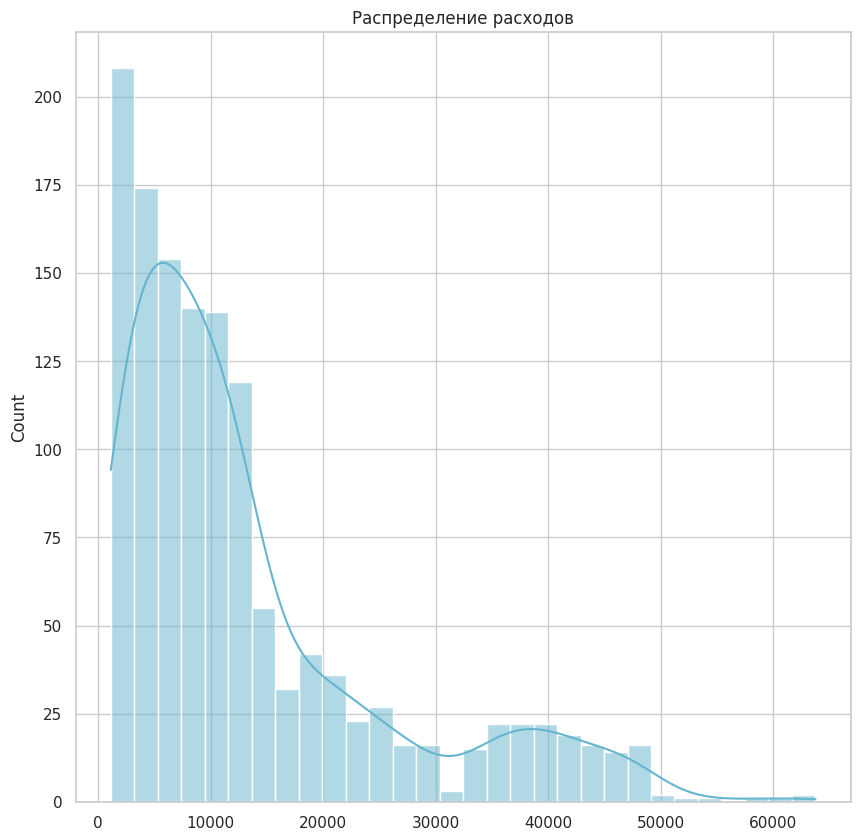

In [ ]:
sns.set(style='whitegrid')
ax = sns.histplot(data=df['charges'].to_numpy(), color = 'c', kde=True)
plt.title('Распределение расходов')

По графику сверху заметно, что распределение асимметрично. Больше всего людей платят в районе 10000 долларов за страховку.

<ipython-input-46-c942b1778eb4>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=charges.head(), y=charges.head().index, palette='Blues')


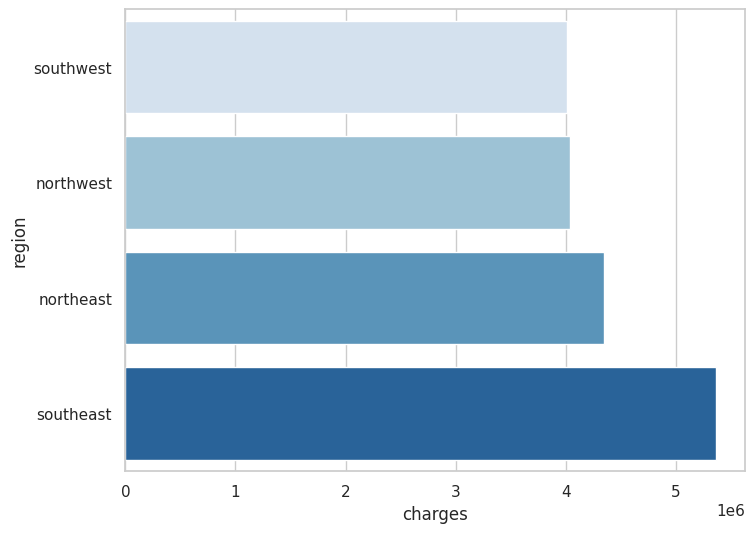

In [ ]:
charges = df['charges'].groupby(df.region).sum().sort_values(ascending = True)
f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax = sns.barplot(x=charges.head(), y=charges.head().index, palette='Blues')

Понятно, что больше всего расходов среди людей из юго-востока, а меньше всего - на юго-западе. Посмотрим на это в зависимости от пола, курения и количества детей.

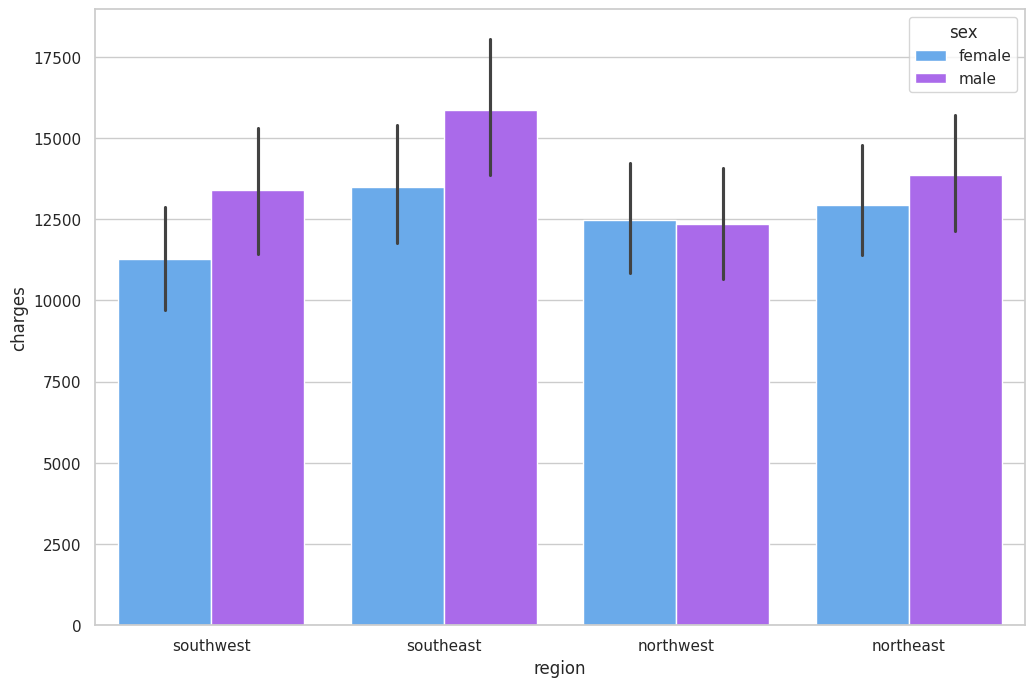

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='region', y='charges', hue='sex', data=df, palette='cool')

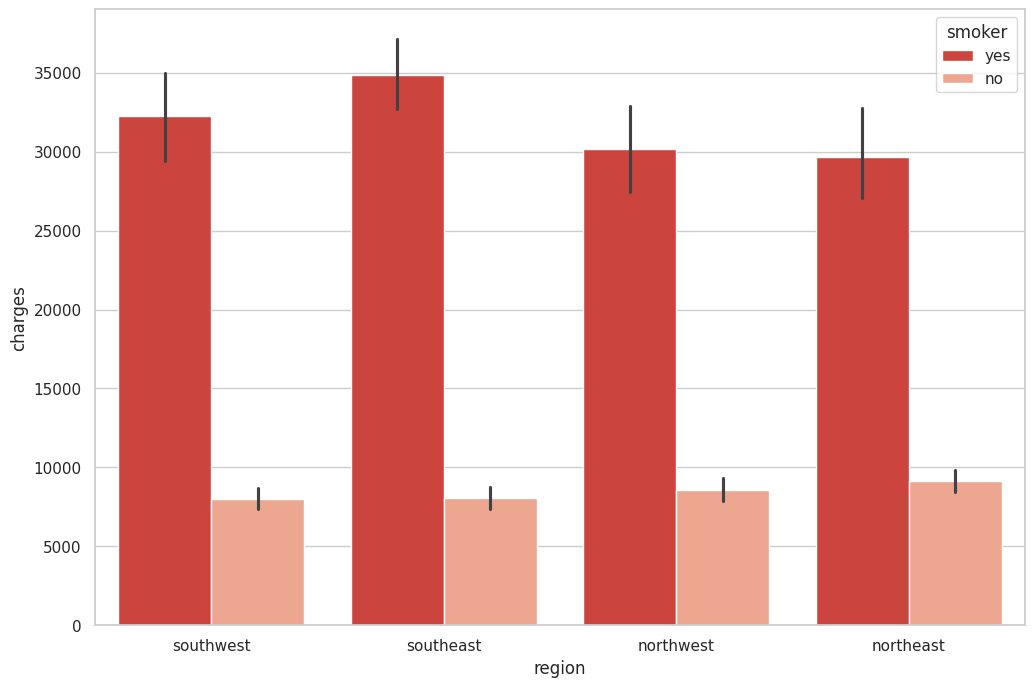

In [ ]:
f, ax = plt.subplots(1,1, figsize=(12,8))
ax = sns.barplot(x = 'region', y = 'charges', hue='smoker', data=df, palette='Reds_r')

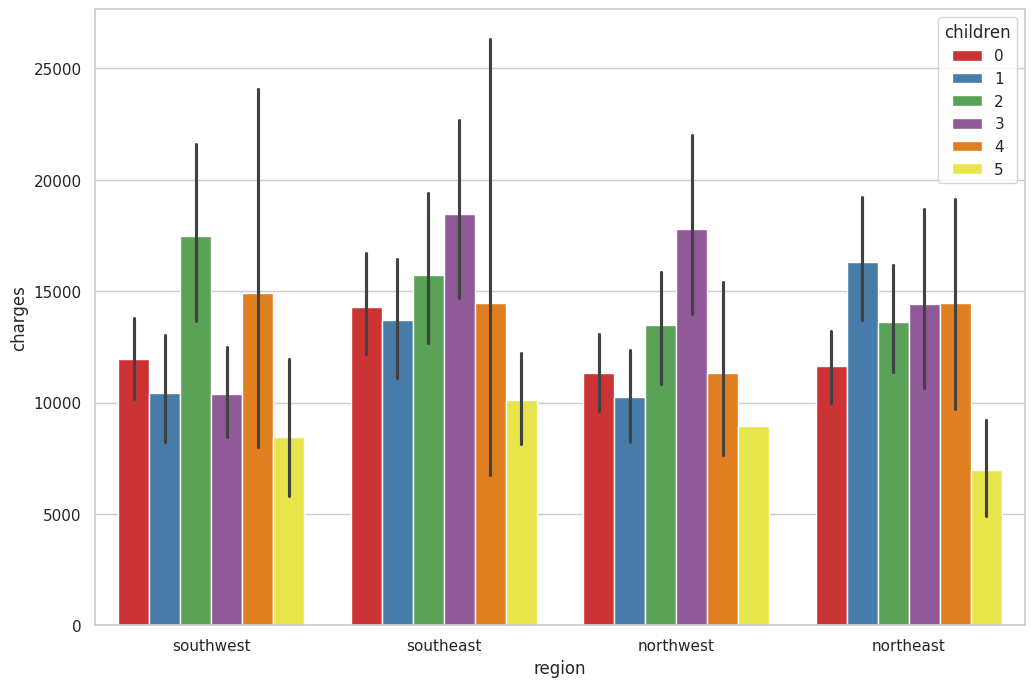

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='region', y='charges', hue='children', data=df, palette='Set1')

Из этих диаграмм можно сделать следующие выводы:
- Курящие имеют большие расходы, чем некурящие
- На юго-востоке курящие имеют самые большие расходы, а на северо-востоке - самые низкие
- На юго-востоке мужчины больше всего платят, там же больше всего платят курящие люди
- У людей с детьми, как правило, больше расходов, чем у людей без детей

Кажется логичным, что курящие вынуждены больше платить за медицинскую страховку. Посмотрим на показатели расходов в зависимости от возраста, индекса массы тела и количества детей, но теперь деля по признаку курения.

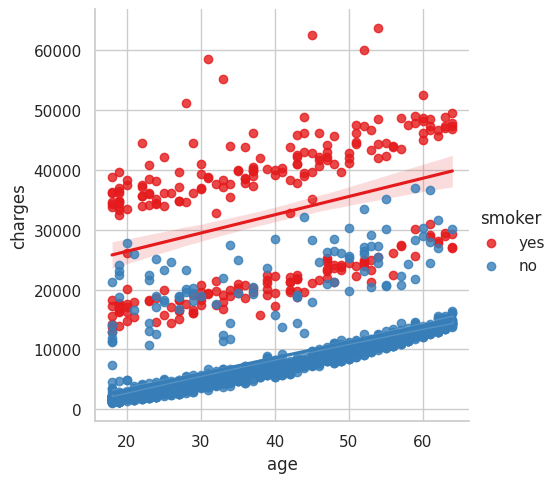

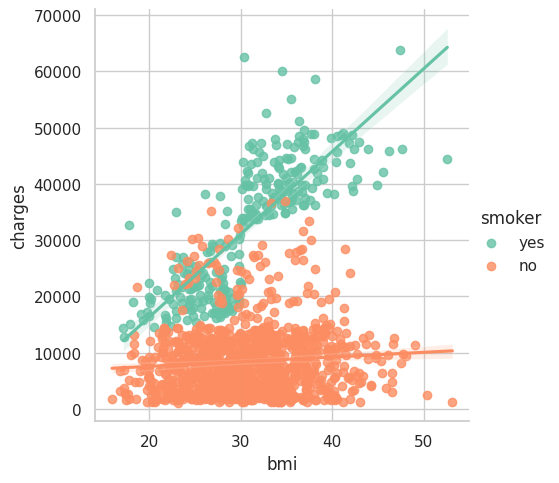

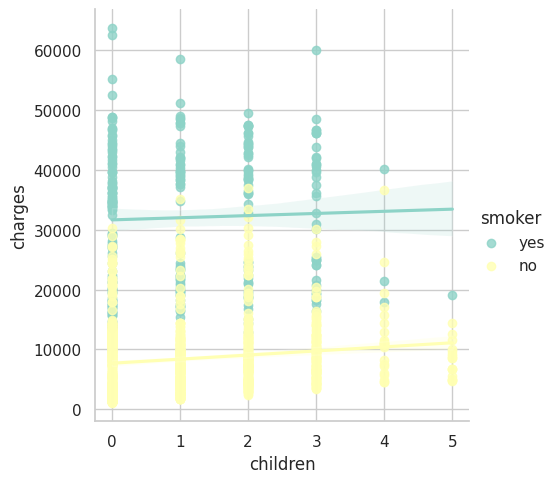

In [ ]:
ax = sns.lmplot(x = 'age', y = 'charges', data=df, hue='smoker', palette='Set1')
ax = sns.lmplot(x = 'bmi', y = 'charges', data=df, hue='smoker', palette='Set2')
ax = sns.lmplot(x = 'children', y = 'charges', data=df, hue='smoker', palette='Set3')

Можно сделать следующие выводы:
- Количество расходов растет с увеличением возраста, индекса массы тела и количества детей
- Среди курящих гораздо меньше тех, у кого есть дети
- У курящих людей расходы очень сильно повышаются. Можно сказать, что пристрастие к курению дает наибольший эффект на медицинские расходы

Последние 2 пункта можно более наглядно продемонстрировать через диаграмму скрипок:

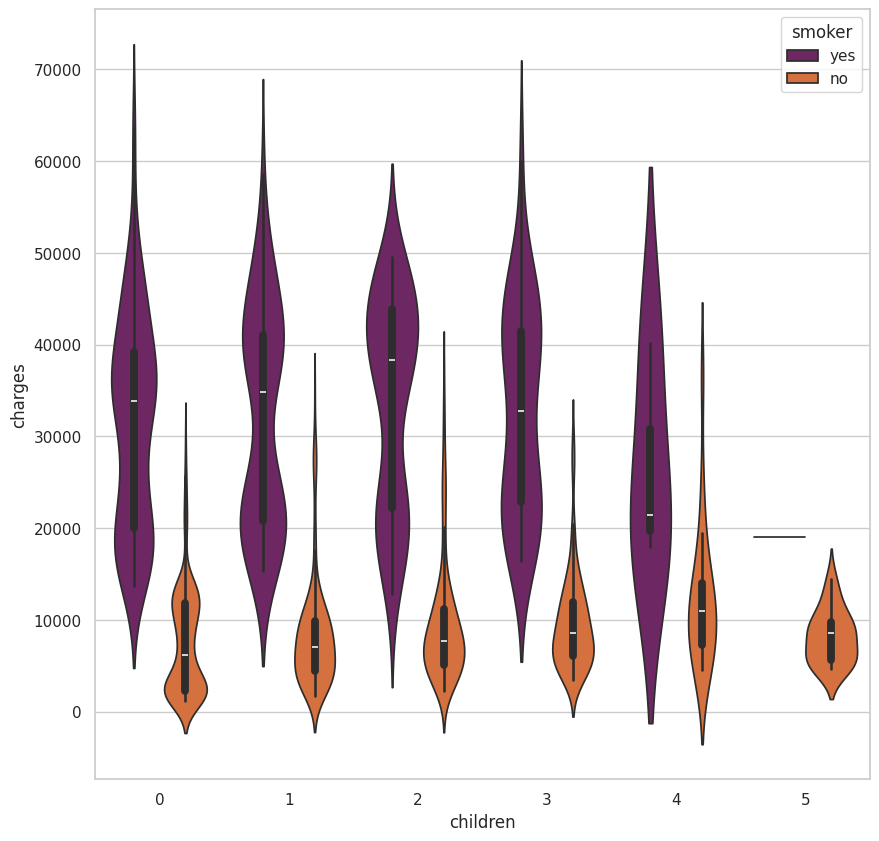

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.violinplot(x = 'children', y = 'charges', data=df, orient='v', hue='smoker', palette='inferno')

Заметим, что у нас есть 3 категориальных признака: пол, курение и регион. Мы можем преобразовать их закодировать:

In [ ]:
numeric_data = df.select_dtypes([np.number])
numeric_features = numeric_data.columns

categorical_columns = ['sex', 'children', 'smoker', 'region']

label = LabelEncoder()
label.fit(df.sex.drop_duplicates())
df.sex = label.transform(df.sex)
label.fit(df.smoker.drop_duplicates())
df.smoker = label.transform(df.smoker)
label.fit(df.region.drop_duplicates())
df.region = label.transform(df.region)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


Теперь мы можем построить диаграмму корреляции

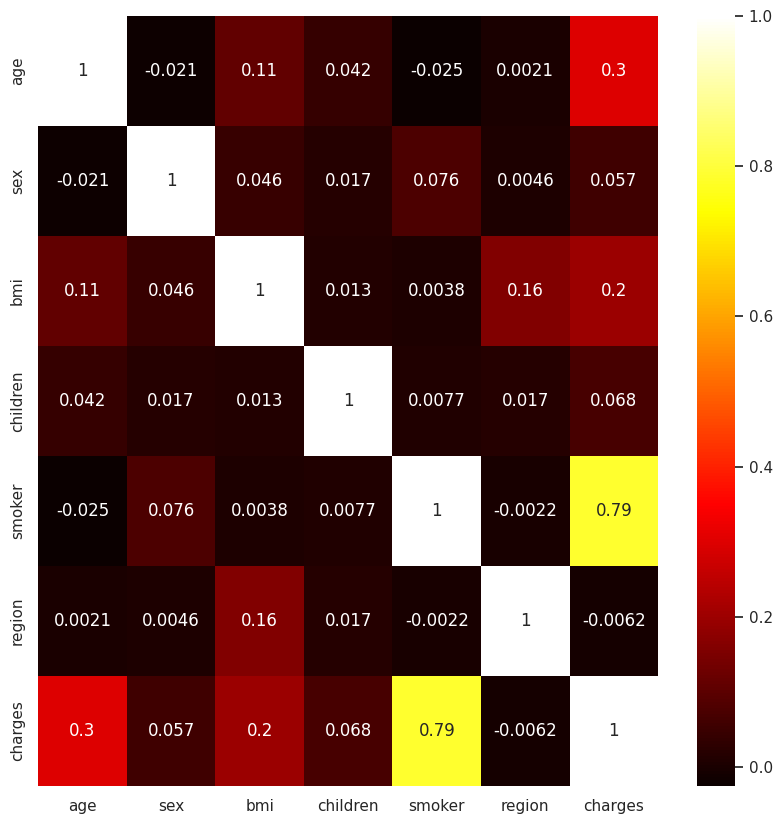

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(df.corr(), annot=True, cmap='hot')

Можно заметить, что наибольшая корреляция наблюдается между курением и количеством расходов. Также заметна корреляция между возрастом и расходами, между индексом массы тела и расходами.

# Разбиение выборки на обучающую и тестовую

In [ ]:
x = df.drop(['charges'], axis=1)
y = df['charges']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Масштабирование признаков

In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
# Переведем в dataframe
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x.columns)
x_train_scaled.head()

,age,sex,bmi,children,smoker,region
0,0.472227,-1.024602,-1.756525,0.734336,-0.508747,-0.456116
1,0.543313,-1.024602,-1.033082,-0.911192,-0.508747,-1.353256
2,0.898745,-1.024602,-0.943687,-0.911192,-0.508747,0.441024
3,-0.025379,-1.024602,0.622393,3.202629,-0.508747,0.441024
4,1.040918,-1.024602,-1.504893,1.557100,-0.508747,-0.456116


# Подбор наилучшего количества (и подмножества) признаков

Для того чтобы выбрать параметры, было решено использовать RFECV с линейной регрессией.

In [ ]:
rfecv = RFECV(estimator=LinearRegression())

rfecv.fit(x_train_scaled, y_train)

selected_features = list(x_train_scaled.columns[rfecv.support_])

print("Оптимальное число признаков: ", rfecv.n_features_)
print("Выбранные признаки: ", selected_features)

Оптимальное число признаков:  4
Выбранные признаки:  ['age', 'bmi', 'children', 'smoker']


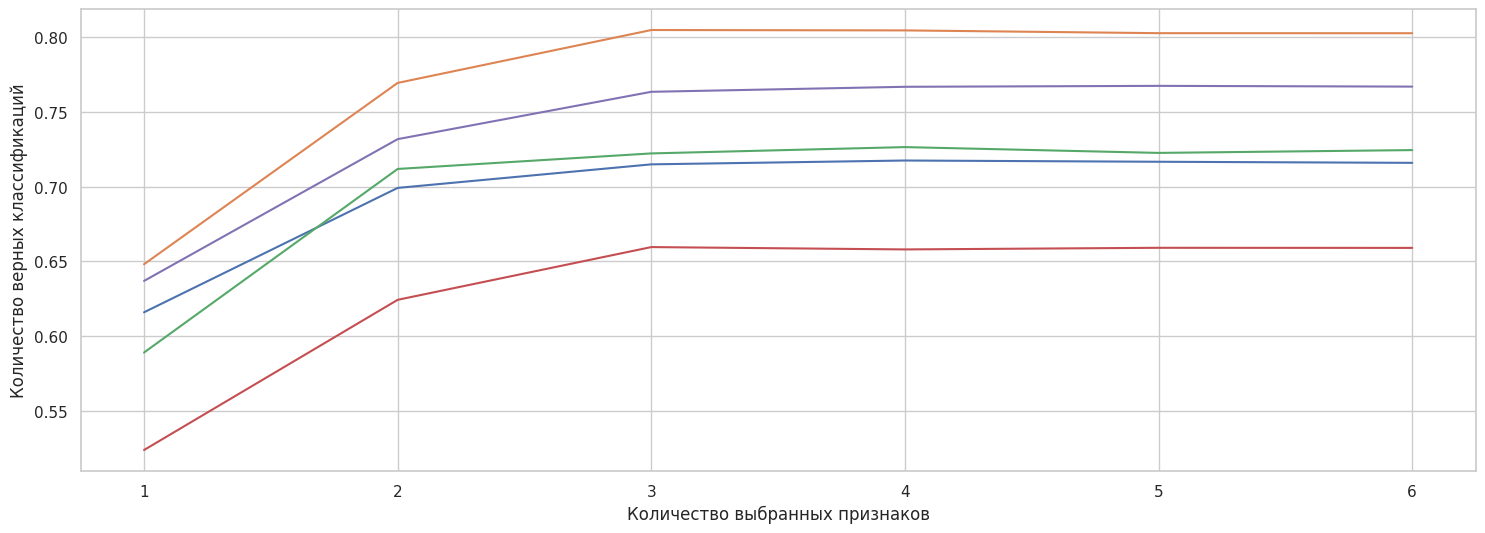

In [ ]:
plt.figure(figsize=(18,6))
plt.xlabel("Количество выбранных признаков")
plt.ylabel("Количество верных классификаций")

for i in range(5):
    key = f'split{i}_test_score'
    features_num = range(1, len(rfecv.cv_results_[key]) + 1)
    plt.plot(features_num, rfecv.cv_results_[key])

plt.show()

В результате подбора выяснилось, что можно избавиться от столбца региона.

In [ ]:
x_train_scaled = x_train_scaled.drop(columns=['region'])
x_test_scaled = x_test_scaled.drop(columns=['region'])
x_train_scaled.head()

,age,sex,bmi,children,smoker
0,0.472227,-1.024602,-1.756525,0.734336,-0.508747
1,0.543313,-1.024602,-1.033082,-0.911192,-0.508747
2,0.898745,-1.024602,-0.943687,-0.911192,-0.508747
3,-0.025379,-1.024602,0.622393,3.202629,-0.508747
4,1.040918,-1.024602,-1.504893,1.557100,-0.508747


# Подбор гиперпараметров

In [ ]:
alpha_grid = np.logspace(-4, 4, 10)
tol_grid = np.logspace(-4, 4, 10)

searcher = GridSearchCV(Ridge(), [{"alpha": alpha_grid, "tol": tol_grid}], scoring="neg_root_mean_squared_error", cv=5)
_ = searcher.fit(x_train_scaled, y_train)

optimal_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f:", optimal_alpha)

optimal_tol = searcher.best_params_["tol"]
print("Best tol = %.4f", optimal_tol)

Best alpha = %.4f: 2.782559402207126
Best tol = %.4f 0.0001


# Обучение библиотечной модели

In [ ]:
model = Ridge(alpha=optimal_alpha, tol=optimal_tol)

model.fit(x_train_scaled, y_train)
y_train_pred2 = model.predict(x_train_scaled)
y_test_pred2 = model.predict(x_test_scaled)
model.coef_

array([ 3.60610447e+03, -2.18081057e+00,  1.97443855e+03,  5.18868521e+02,
        9.53414382e+03])

Оценим точность предсказания библиотечной линейной регрессии. Как видим, отличий от нашей реализации почти не наблюдается.

In [ ]:
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_test_pred2, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred2, squared=False))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_test_pred2, squared=True))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred2, squared=True))
print("Test MAE = %.4f" % mean_absolute_error(y_test, y_test_pred2))
print("Train MAE = %.4f" % mean_absolute_error(y_train, y_train_pred2))
print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_test_pred2))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred2))
print("Test R^2 = %.4f" % r2_score(y_test, y_test_pred2))
print("Train R^2 = %.4f" % r2_score(y_train, y_train_pred2))

Test RMSE = 5830.6973
Train RMSE = 6113.1277
Test MSE = 33997031.1960
Train MSE = 37370330.8121
Test MAE = 4217.9475
Train MAE = 4213.8607
Test MAPE = 0.4815
Train MAPE = 0.4227
Test R^2 = 0.7810
Train R^2 = 0.7411


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

# Обучение своей модели градиентного возраста

In [ ]:
gradient_model = GDLinearRegression(alpha=optimal_alpha, tol=optimal_tol)
gradient_model.fit(x_train_scaled, y_train)
gradient_model.w

array([ 1.33114729e+04,  3.60610447e+03, -2.18081052e+00,  1.97443855e+03,
        5.18868521e+02,  9.53414382e+03])

Оценим точность предсказания градиентного спуска через разные метрики.

In [ ]:
y_train_pred1 = linear_model(gradient_model.w, x_train_scaled)
y_test_pred1 = linear_model(gradient_model.w, x_test_scaled)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_test_pred1, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred1, squared=False))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_test_pred1, squared=True))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred1, squared=True))
print("Test MAE = %.4f" % mean_absolute_error(y_test, y_test_pred1))
print("Train MAE = %.4f" % mean_absolute_error(y_train, y_train_pred1))
print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_test_pred1))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred1))
print("Test R^2 = %.4f" % r2_score(y_test, y_test_pred1))
print("Train R^2 = %.4f" % r2_score(y_train, y_train_pred1))

Test RMSE = 5829.4332
Train RMSE = 6113.2258
Test MSE = 33982291.0823
Train MSE = 37371529.1342
Test MAE = 4208.1308
Train MAE = 4204.8526
Test MAPE = 0.4786
Train MAPE = 0.4203
Test R^2 = 0.7811
Train R^2 = 0.7411


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

# Обучение своей модели стохастического градиентного спуска

In [ ]:
sgd_model = SGDLinearRegression(alpha=optimal_alpha, tol=optimal_tol, iterations_cnt=10_000)
sgd_model.fit(x_train_scaled.to_numpy(), y_train.to_numpy())
sgd_model.w

array([[3155.83256822],
       [ -10.51135792],
       [-374.92553121],
       [ 957.72493386],
       [ -71.46454902],
       [1988.95230502]])

Оценим точность предсказания стохастического градиентного спуска через разные метрики.

In [ ]:
y_train_pred3 = linear_model(sgd_model.w, x_train_scaled)
y_test_pred3 = linear_model(sgd_model.w, x_test_scaled)
y_test_pred3 = y_test_pred3.reshape(y_test_pred3.shape[0],)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_test_pred3, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred3, squared=False))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_test_pred3, squared=True))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred3, squared=True))
print("Test MAE = %.4f" % mean_absolute_error(y_test, y_test_pred3))
print("Train MAE = %.4f" % mean_absolute_error(y_train, y_train_pred3))
print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_test_pred3))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred3))
print("Test R^2 = %.4f" % r2_score(y_test, y_test_pred3))
print("Train R^2 = %.4f" % r2_score(y_train, y_train_pred3))

Test RMSE = 14495.7422
Train RMSE = 14558.4292
Test MSE = 210126540.6136
Train MSE = 211947859.3354
Test MAE = 9870.1015
Train MAE = 10338.5283
Test MAPE = 0.6596
Train MAPE = 0.7030
Test R^2 = -0.3535
Train R^2 = -0.4685


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

Мы получили результаты, которые очень сильно хуже других моделей. Проблема в том, что стохастический градиентный спуск сходится очень медленно, поэтому дождаться сходимости через условие остановки очень сложно. Пришлось добавить параметр для ограничения количества итераций, чтобы получить хоть какие-то результаты.

# Обучение своей модели мини-пакетного градиентного спуска

In [ ]:
mini_batch_model = MiniBatchGDLinearRegression(batch_size=x_train_scaled.shape[0] // 50)
mini_batch_model.fit(x_train_scaled.to_numpy(), y_train.to_numpy())
mini_batch_model.w

array([2297.88752826, 1386.2954864 , 2464.74774585, -451.74229764,
       8666.97984289])

Оценим точность предсказания мини-пакетного градиентного спуска через разные метрики.

In [ ]:
y_train_pred4 = np.dot(x_train_scaled, mini_batch_model.w) + mini_batch_model.cost
y_test_pred4 = np.dot(x_test_scaled, mini_batch_model.w) + mini_batch_model.cost

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_test_pred4, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred4, squared=False))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_test_pred4, squared=True))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred4, squared=True))
print("Test MAE = %.4f" % mean_absolute_error(y_test, y_test_pred4))
print("Train MAE = %.4f" % mean_absolute_error(y_train, y_train_pred4))
print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_test_pred4))
print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred4))
print("Test R^2 = %.4f" % r2_score(y_test, y_test_pred4))
print("Train R^2 = %.4f" % r2_score(y_train, y_train_pred4))

Test RMSE = 6458.1962
Train RMSE = 6540.1307
Test MSE = 41708298.3174
Train MSE = 42773309.3099
Test MAE = 4970.8973
Train MAE = 4828.6209
Test MAPE = 0.7658
Train MAPE = 0.6515
Test R^2 = 0.7313
Train R^2 = 0.7036


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

Видно, что результаты не сильно отличаются от библиотечной модели

Если мы построим графики оценки MPE для двух предсказателей, то увидим, что они почти не отличимы.

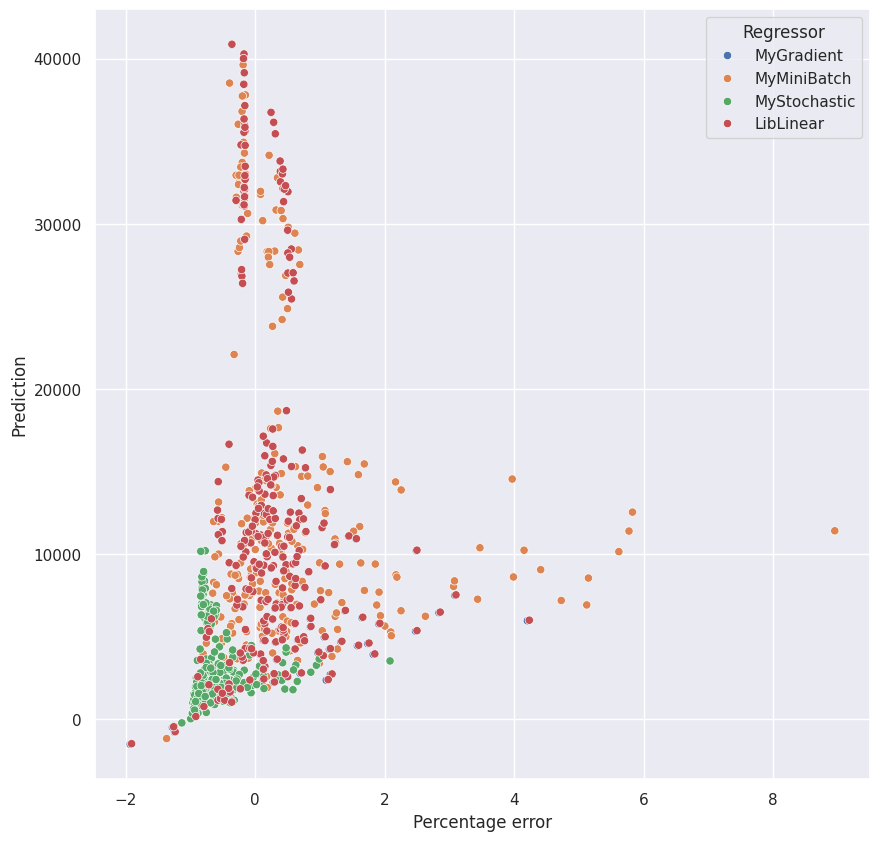

In [ ]:
df1=pd.DataFrame({'Prediction': y_test_pred1, 'Percentage error': (y_test_pred1 - y_test)/y_test, "Regressor":"MyGradient"},
                 columns=['Prediction', 'Percentage error', "Regressor"])
df2=pd.DataFrame({'Prediction': y_test_pred4, 'Percentage error': (y_test_pred4 - y_test)/y_test,
                  "Regressor":"MyMiniBatch"}, columns=['Prediction', 'Percentage error','Regressor'])
df3=pd.DataFrame({'Prediction': y_test_pred3, 'Percentage error': (y_test_pred3 - y_test)/y_test,
                  "Regressor":"MyStochastic"}, columns=['Prediction', 'Percentage error','Regressor'])
df4=pd.DataFrame({'Prediction': y_test_pred2, 'Percentage error': (y_test_pred2 - y_test)/y_test,
                  "Regressor":"LibLinear"}, columns=['Prediction', 'Percentage error','Regressor'])


sns.set(rc={'figure.figsize':(10,10)})
rbf_poly_scatter=sns.scatterplot(data=pd.concat([df1, df2, df3, df4]),y="Prediction", x="Percentage error", hue='Regressor')


Можно увидеть, что мои реализации в плане предсказательной способности практически не отличаются от библиотечной реализации (кроме стохастического градиентного спуска)

# Кросс-валидация и таблица результатов

Построим результаты для реализации градиентного спуска

In [ ]:
fold = KFold(n_splits=5)

results = pd.DataFrame(index=[
    'mse-train', 'mse-test', 'rmse-train', 'rmse-test', 'r2-train', 'r2-test'
])

splited_samples = fold.split(X=x_train_scaled, y=y_train)

model = GDLinearRegression(alpha=optimal_alpha, tol=optimal_tol)

for fold_i, (train_i, test_i) in enumerate(splited_samples):
    cur_x_train = x_train_scaled.iloc[train_i, :]
    cur_x_test = x_train_scaled.iloc[test_i, :]
    cur_y_train = y_train.iloc[train_i]
    cur_y_test = y_train.iloc[test_i]

    model.fit(cur_x_train, cur_y_train)
    cur_w = model.w

    y_predf_train = linear_model(cur_w, cur_x_train)
    y_predf_test = linear_model(cur_w, cur_x_test)

    mse_train = mean_squared_error(cur_y_train, y_predf_train, squared=True)
    mse_test = mean_squared_error(cur_y_test, y_predf_test, squared=True)

    rmse_train = mean_squared_error(cur_y_train, y_predf_train, squared=False)
    rmse_test = mean_squared_error(cur_y_test, y_predf_test, squared=False)

    r2_train = r2_score(cur_y_train, y_predf_train)
    r2_test = r2_score(cur_y_test, y_predf_test)

    results.insert(loc=fold_i, column=f"Fold{fold_i + 1}", value=[
        mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test
    ])

E = results.mean(axis=1)
std = results.std(axis=1)
results["E"] = E
results["STD"] = std

results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-train,3.675900e+07,3.887028e+07,3.784412e+07,3.513760e+07,3.798876e+07,3.731995e+07,1.432034e+06
mse-test,4.002669e+07,3.164726e+07,3.591237e+07,4.651143e+07,3.513653e+07,3.784686e+07,5.686597e+06
rmse-train,6.062920e+03,6.234604e+03,6.151757e+03,5.927698e+03,6.163502e+03,6.108096e+03,1.178607e+02
rmse-test,6.326665e+03,5.625590e+03,5.992693e+03,6.819929e+03,5.927608e+03,6.138497e+03,4.551272e+02
r2-train,7.466655e-01,7.212460e-01,7.440995e-01,7.599481e-01,7.338171e-01,7.411552e-01,1.451234e-02
r2-test,7.165991e-01,8.047571e-01,7.229444e-01,6.584234e-01,7.660764e-01,7.337601e-01,5.516341e-02


Построим результаты для библиотечной модели

In [ ]:
model = Ridge(alpha=optimal_alpha, tol=optimal_tol)
results_ridge = pd.DataFrame(index=[
    'mse_train', 'mse_test', 'rmse_train',  'rmse_test', 'r2_train', 'r2_test'
])

mse_train = cross_val_score(model, x_train_scaled, y_train, cv=5, scoring="neg_mean_squared_error")
mse_test = cross_val_score(model, x_test_scaled, y_test, cv=5, scoring="neg_mean_squared_error")
rmse_train = cross_val_score(model, x_train_scaled, y_train, cv=5, scoring="neg_root_mean_squared_error")
rmse_test = cross_val_score(model, x_test_scaled, y_test, cv=5, scoring="neg_root_mean_squared_error")
r2_train = cross_val_score(model, x_train_scaled, y_train, cv=5, scoring="r2")
r2_test = cross_val_score(model, x_test_scaled, y_test, cv=5, scoring="r2")

for fold_i in range(5):
    results_ridge.insert(loc=fold_i, column=f"Fold{fold_i + 1}", value=[
        -mse_train[fold_i], -mse_test[fold_i], -rmse_train[fold_i], -rmse_test[fold_i], r2_train[fold_i], r2_test[fold_i]
    ])

E = results_ridge.mean(axis=1)
std = results_ridge.std(axis=1)
results_ridge["E"] = E
results_ridge["STD"] = std
results_ridge

,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse_train,3.999973e+07,3.168069e+07,3.592262e+07,4.650673e+07,3.511289e+07,3.784453e+07,5.675102e+06
mse_test,2.638492e+07,3.599929e+07,3.993535e+07,4.027366e+07,3.679708e+07,3.587806e+07,5.629431e+06
rmse_train,6.324534e+03,5.628560e+03,5.993548e+03,6.819584e+03,5.925613e+03,6.138368e+03,4.541076e+02
rmse_test,5.136625e+03,5.999941e+03,6.319442e+03,6.346153e+03,6.066060e+03,5.973644e+03,4.919788e+02
r2_train,7.167900e-01,8.045508e-01,7.228653e-01,6.584579e-01,7.662338e-01,7.337796e-01,5.509756e-02
r2_test,8.442879e-01,7.190738e-01,7.444257e-01,6.846574e-01,8.100247e-01,7.604939e-01,6.557384e-02


In [ ]:
fold = KFold(n_splits=5)

results = pd.DataFrame(index=[
    'mse-train', 'mse-test', 'rmse-train', 'rmse-test', 'r2-train', 'r2-test'
])

splited_samples = fold.split(X=x_train_scaled, y=y_train)

model = SGDLinearRegression(alpha=optimal_alpha, tol=optimal_tol)

for fold_i, (train_i, test_i) in enumerate(splited_samples):
    cur_x_train = x_train_scaled.iloc[train_i, :]
    cur_x_test = x_train_scaled.iloc[test_i, :]
    cur_y_train = y_train.iloc[train_i]
    cur_y_test = y_train.iloc[test_i]

    model.fit(cur_x_train.to_numpy(), cur_y_train.to_numpy())
    cur_w = model.w

    y_predf_train = linear_model(cur_w, cur_x_train)
    y_predf_test = linear_model(cur_w, cur_x_test)

    mse_train = mean_squared_error(cur_y_train, y_predf_train, squared=True)
    mse_test = mean_squared_error(cur_y_test, y_predf_test, squared=True)

    rmse_train = mean_squared_error(cur_y_train, y_predf_train, squared=False)
    rmse_test = mean_squared_error(cur_y_test, y_predf_test, squared=False)

    r2_train = r2_score(cur_y_train, y_predf_train)
    r2_test = r2_score(cur_y_test, y_predf_test)

    results.insert(loc=fold_i, column=f"Fold{fold_i + 1}", value=[
        mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test
    ])

E = results.mean(axis=1)
std = results.std(axis=1)
results["E"] = E
results["STD"] = std

results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-train,1.969639e+08,2.004528e+08,1.825954e+08,1.979224e+08,1.846218e+08,1.925112e+08,8.257440e+06
mse-test,1.986943e+08,2.365093e+08,1.639613e+08,1.942248e+08,1.800134e+08,1.946806e+08,2.704051e+07
rmse-train,1.403438e+04,1.415813e+04,1.351278e+04,1.406849e+04,1.358756e+04,1.387227e+04,2.986588e+02
rmse-test,1.409590e+04,1.537886e+04,1.280474e+04,1.393645e+04,1.341691e+04,1.392657e+04,9.560560e+02
r2-train,-3.574290e-01,-4.375251e-01,-2.347029e-01,-3.521592e-01,-2.936243e-01,-3.350881e-01,7.596103e-02
r2-test,-4.068151e-01,-4.591080e-01,-2.649237e-01,-4.263726e-01,-1.984504e-01,-3.511339e-01,1.130974e-01


Построим результаты для мини-пакетного градиентного спуска

In [ ]:
fold = KFold(n_splits=5)

results = pd.DataFrame(index=[
    'mse-train', 'mse-test', 'rmse-train', 'rmse-test', 'r2-train', 'r2-test'
])

splited_samples = fold.split(X=x_train_scaled, y=y_train)

model = MiniBatchGDLinearRegression(alpha=optimal_alpha, tol=optimal_tol)

for fold_i, (train_i, test_i) in enumerate(splited_samples):
    cur_x_train = x_train_scaled.iloc[train_i, :]
    cur_x_test = x_train_scaled.iloc[test_i, :]
    cur_y_train = y_train.iloc[train_i]
    cur_y_test = y_train.iloc[test_i]

    model.fit(cur_x_train.to_numpy(), cur_y_train.to_numpy())
    cur_w = model.w

    y_predf_train = np.dot(cur_x_train, mini_batch_model.w) + mini_batch_model.cost
    y_predf_test = np.dot(cur_x_test, mini_batch_model.w) + mini_batch_model.cost

    mse_train = mean_squared_error(cur_y_train, y_predf_train, squared=True)
    mse_test = mean_squared_error(cur_y_test, y_predf_test, squared=True)

    rmse_train = mean_squared_error(cur_y_train, y_predf_train, squared=False)
    rmse_test = mean_squared_error(cur_y_test, y_predf_test, squared=False)

    r2_train = r2_score(cur_y_train, y_predf_train)
    r2_test = r2_score(cur_y_test, y_predf_test)

    results.insert(loc=fold_i, column=f"Fold{fold_i + 1}", value=[
        mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test
    ])

E = results.mean(axis=1)
std = results.std(axis=1)
results["E"] = E
results["STD"] = std

results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-train,4.185873e+07,4.431291e+07,4.362137e+07,4.108044e+07,4.299309e+07,4.277331e+07,1.307681e+06
mse-test,4.643162e+07,3.661491e+07,3.938106e+07,4.954477e+07,4.189418e+07,4.277331e+07,5.230726e+06
rmse-train,6.469832e+03,6.656794e+03,6.604648e+03,6.409403e+03,6.556912e+03,6.539518e+03,1.001051e+02
rmse-test,6.814075e+03,6.051026e+03,6.275433e+03,7.038805e+03,6.472572e+03,6.530382e+03,3.990923e+02
r2-train,7.115194e-01,6.822148e-01,7.050339e-01,7.193481e-01,6.987523e-01,7.033737e-01,1.408319e-02
r2-test,6.712502e-01,7.741099e-01,6.961842e-01,6.361468e-01,7.210869e-01,6.997556e-01,5.209361e-02


# Выводы

Мы имеем, что написанная модель линейной регрессии с градиентным спуском и мини-пакетным градиентным спуском почти полностью совпадает по точности с моделью Ridge библиотеки sklearn.
Причем совпадение наблюдается как до, так и после кроссвалидации.